# To make a phase curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet as jl
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rcParams
from pylab import *

In [2]:
# For font etc. styling

sns.set_context("talk")
sns.set_style("ticks")

# Fonts:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
matplotlib.rcParams.update({'font.size':12})
plt.rc('legend', **{'fontsize':12})

# Ticks to the outside:
rcParams['axes.linewidth'] = 1.2 
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

In [3]:
# To load data from the folder
dataset = jl.load(input_folder='multisector_in_transit_ExpMatern')

In [4]:
# Creating result object
res1 = dataset.fit(sampler='dynamic_dynesty')

Detected dynamic_dynesty sampler output files --- extracting from multisector_in_transit_ExpMatern/_dynesty_DNS_posteriors.pkl


In [5]:
# Making phases
P, t0 = np.median(res1.posteriors['posterior_samples']['P_p1']),\
        np.median(res1.posteriors['posterior_samples']['t0_p1'])

phases = jl.get_phases(dataset.times_lc['TESS2'], P, t0)

(-0.025, 0.025)

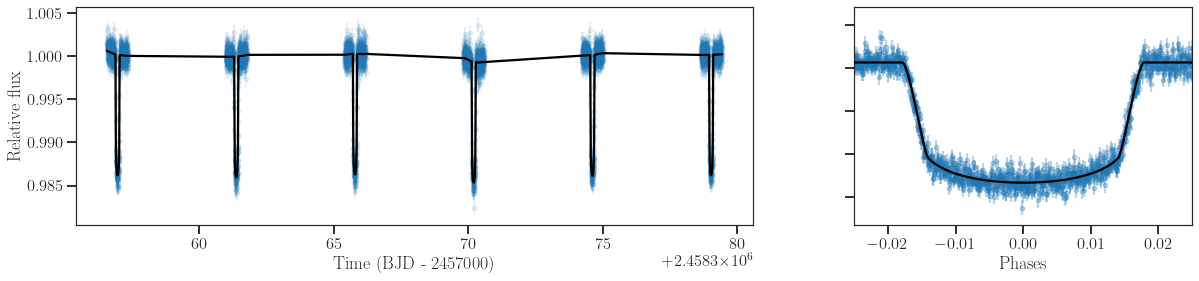

In [6]:
# Extract full model:
transit_plus_GP_model = res1.lc.evaluate('TESS2')

# Deterministic part of the model (in our case transit divided by mflux):
transit_model = res1.lc.model['TESS2']['deterministic']

# GP part of the model:
gp_model = res1.lc.model['TESS2']['GP']

# Now plot. First preambles:
fig = plt.figure(figsize=(20,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot data
ax1.errorbar(dataset.times_lc['TESS2'], dataset.data_lc['TESS2'], \
             yerr = dataset.errors_lc['TESS2'], fmt = '.', alpha = 0.1)

# Plot the (full, transit + GP) model:
ax1.plot(dataset.times_lc['TESS2'], transit_plus_GP_model, color='black',zorder=10)

#ax1.set_xlim([1328,1350])
#ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

ax2 = plt.subplot(gs[1])

# Now plot phase-folded lightcurve but with the GP part removed:
ax2.errorbar(phases, dataset.data_lc['TESS2'] - gp_model, \
             yerr = dataset.errors_lc['TESS2'], fmt = '.', alpha = 0.3)

# Plot transit-only (divided by mflux) model:
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black',zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.set_xlabel('Phases')
ax2.set_xlim([-0.025,0.025])
#ax2.set_ylim([0.96,1.04])

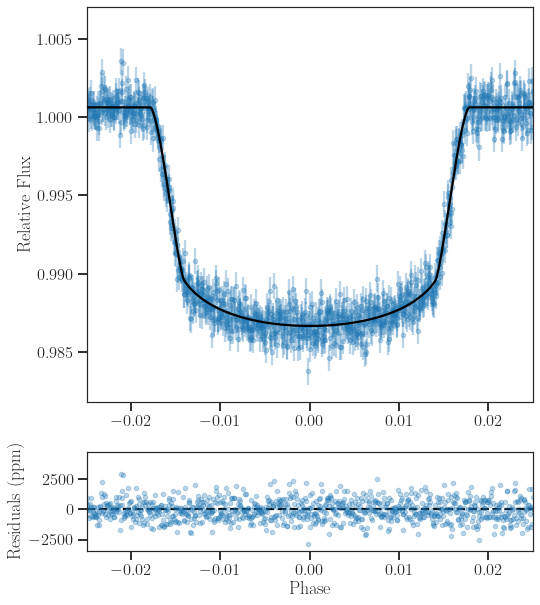

In [7]:
data_phs = dataset.data_lc['TESS2'] - gp_model
data_err_phs = dataset.errors_lc['TESS2']

resid = (data_phs - transit_model)*1e6

fig_a = plt.figure(figsize = (8,10))
gs_a = gridspec.GridSpec(2, 1, height_ratios = [4,1])

ax11 = plt.subplot(gs_a[0])
ax11.errorbar(phases, data_phs, yerr=data_err_phs, fmt='.', alpha=0.3)
ax11.plot(phases[idx], transit_model[idx], c='black', zorder=10)
ax11.set_ylabel('Relative Flux')

ax22 = plt.subplot(gs_a[1], sharex = ax11)
ax22.errorbar(phases, resid, fmt='.', alpha=0.3)
ax22.axhline(y=0.0, c='black', ls='--')
ax22.set_ylabel('Residuals (ppm)')


plt.xlim([-0.025, 0.025])
plt.xlabel('Phase')

plt.savefig('phot_planet1_instrument_TESS.pdf')